In [1]:
#importing dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re


from wordcloud import WordCloud, STOPWORDS
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score


In [2]:
#read the tweets data
tweets_df = pd.read_csv("Tweets_source_data.csv")
# 
len(tweets_df)
tweets_df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


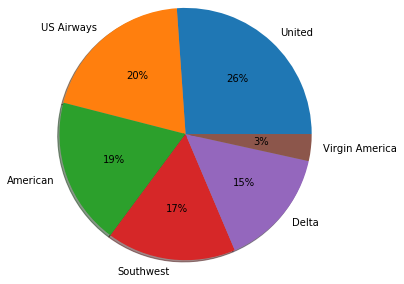

In [3]:
#displays tweets share by airlines
tweets_df.airline.value_counts().plot(kind='pie', autopct='%1.0f%%', radius=1.45, label='',shadow=True)
plt.savefig('../images/airlinestweets.png')

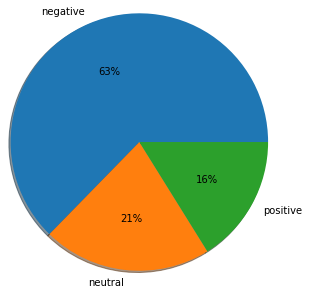

In [4]:
#display count of the different sentiments - negative, neutral, positive
tweets_df.airline_sentiment.value_counts().plot(kind='pie', autopct='%1.0f%%', radius=1.48, label='',shadow=True)
plt.savefig('../images/tweetsenti.png')

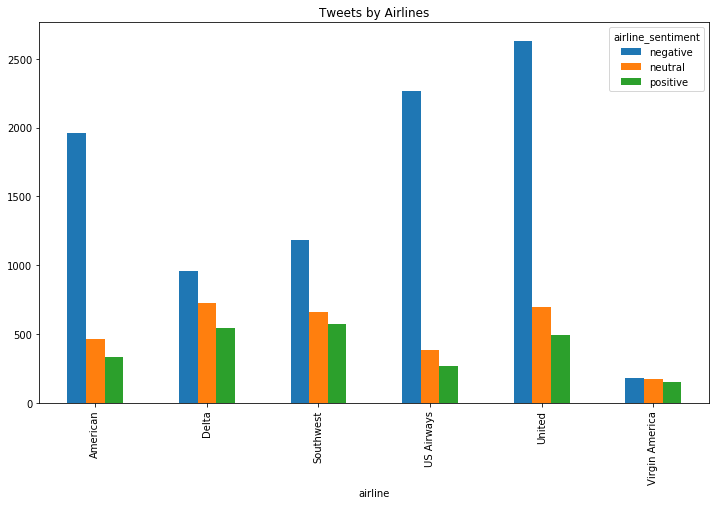

In [5]:
#represent sentiments by airlines on a bar chart
tweets_df.groupby(['airline', 'airline_sentiment']).airline_sentiment.count().unstack().plot(kind='bar', figsize=(12,7), legend=True, title='Tweets by Airlines')
plt.savefig('../images/tweets_by_sent.png')
#plt.legend(loc='best')
# sentiment_airline.plot(kind='bar', loc='best')

# sns.catplot(x="airline", y="countval", hue="airline_sentiment", data=sentiment_airline,
#             height=6, kind="bar", palette="muted")

# Text Processing
- Looking through the different tweets

In [6]:
#processing each individual tweet, by removing multiple spaces, single character, airline name
tweets = tweets_df['text']
tweets

processed_tweets = []

for line in range(0, len(tweets)):
#     proc_line = tweets[line].split()[1:]
    # Remove all the special characters
    proc_line = re.sub(r'\W', ' ', str(tweets[line]))

    # remove all single characters
    proc_line= re.sub(r'\s+[a-zA-Z]\s+', ' ', proc_line)

    # Remove single characters from the start
    proc_line = re.sub(r'\^[a-zA-Z]\s+', ' ', proc_line) 

    # Substituting multiple spaces with single space
    proc_line = re.sub(r'\s+', ' ', proc_line, flags=re.I)

    # Removing prefixed 'b'
    proc_line = re.sub(r'^b\s+', '', proc_line)

    # Converting to Lowercase
    proc_line = proc_line.lower()
    
    # remove the name of the airline
    proc_line = ' '.join(proc_line.split()[1:])
    
    # add to the created list
    processed_tweets.append(proc_line)
    

#add a new column to the df with the clean tweet
tweets_df['tweets'] = processed_tweets
#tweets_df.head()


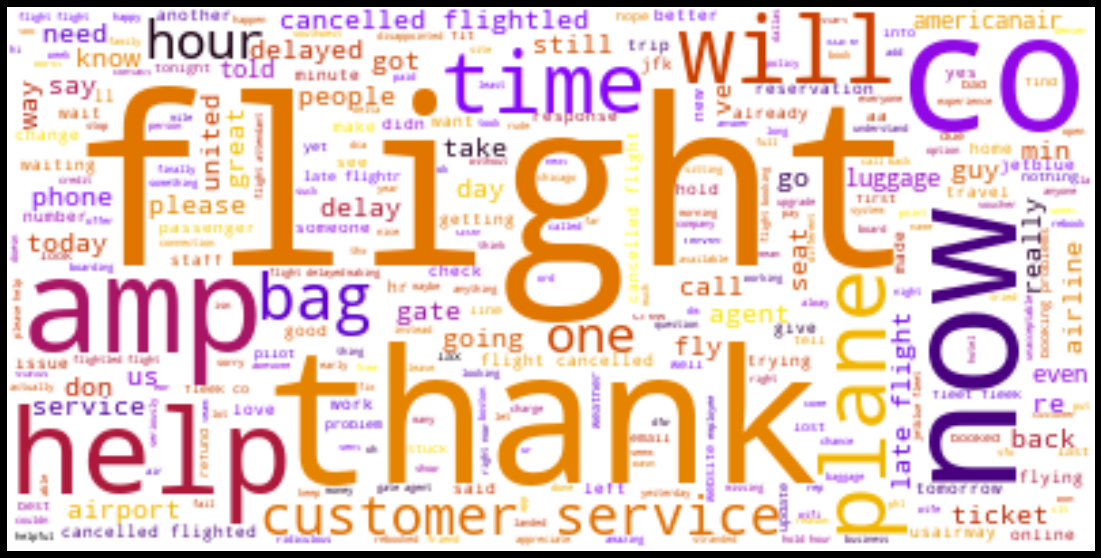

In [7]:
#create a word cloud of the most popular word in the tweets.
def wordcloud(tweets,col):
    stopwords = set(STOPWORDS)
    wordcloud = WordCloud(background_color='white', colormap="gnuplot", contour_color='steelblue', max_words=2000, stopwords=stopwords).generate(" ".join([i for i in tweets[col]]))
    plt.figure( figsize=(20,10), facecolor='k')
    plt.imshow(wordcloud, cmap=plt.cm.gray, interpolation="bilinear")
    plt.axis("off")
    plt.savefig('../images/wordcloud.png')
wordcloud(tweets_df,'tweets')  

# Creating a Model
- We will classify and use only the top 5000 words that occur in 80% of the sentences.
- We will use random forest classification 

In [8]:
#creating a vectorizer to be used for classification
vectorizer = TfidfVectorizer (max_features=5000, min_df=7, max_df=0.8, stop_words=stopwords.words('english'))
processed_tweets = vectorizer.fit_transform(processed_tweets).toarray()

In [9]:
#setting our train and test data
airlines = tweets_df['airline']
sentiments = tweets_df['airline_sentiment']
X_train, X_test, y_train, y_test = train_test_split(processed_tweets, sentiments, test_size=0.2, random_state=0)

In [10]:
#train our model
text_classifier = RandomForestClassifier(n_estimators=200, random_state=0)
text_classifier.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [11]:
#make prediction
predictions = text_classifier.predict(X_test)

In [12]:
#generating reports

print(confusion_matrix(y_test,predictions))
print(classification_report(y_test,predictions))
print(accuracy_score(y_test, predictions))

[[1686  131   53]
 [ 289  275   50]
 [ 138   55  251]]
              precision    recall  f1-score   support

    negative       0.80      0.90      0.85      1870
     neutral       0.60      0.45      0.51       614
    positive       0.71      0.57      0.63       444

    accuracy                           0.76      2928
   macro avg       0.70      0.64      0.66      2928
weighted avg       0.74      0.76      0.74      2928

0.755464480874317


# Other models


In [13]:
from sklearn.datasets import make_regression

n_features = len(sentiments.unique())
X, y = make_regression(n_samples=30, n_features=n_features, 
                       n_informative=n_features, random_state=42, 
                       noise=0.5, bias=100.0)
print(X.shape)

(30, 3)


In [14]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()

# Fitting our model with all of our features in X
model.fit(X, y)

score = model.score(X, y)
print(f"R2 Score: {score}")

R2 Score: 0.9999838079561165


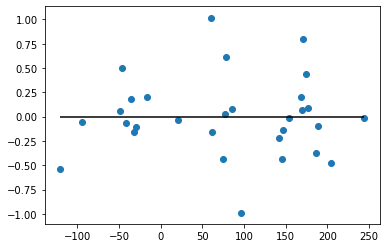

In [15]:
predictions = model.predict(X)
# Plot Residuals
plt.scatter(predictions, predictions - y)
plt.hlines(y=0, xmin=predictions.min(), xmax=predictions.max())
plt.show()

In [16]:
tweets_df['target'] = 0
x = tweets_df.tweets
y = tweets_df.target

In [17]:
from sklearn.cross_validation import train_test_split
SEED = 2000
x_train, x_validation_and_test, y_train, y_validation_and_test = train_test_split(x, y, test_size=.02, random_state=SEED)
x_validation, x_test, y_validation, y_test = train_test_split(x_validation_and_test, y_validation_and_test, test_size=.5, random_state=SEED)

ModuleNotFoundError: No module named 'sklearn.cross_validation'